In [ ]:
!pip install pycaret
!pip install six
!pip install shap

In [ ]:
import numpy as np
import pandas as pd

from pycaret.utils import enable_colab
enable_colab()
from pycaret.classification import *

import six
import sys
sys.modules['sklearn.externals.six'] = six

Colab mode activated.


In [ ]:
# Load data
df = pd.read_csv("hotel-data.csv").drop(columns=['index', 'check_in_date', 'check_out_date'])

In [ ]:
# Basic preprocessing
df['booking_date'] = pd.to_datetime(df['booking_date'])

df['Country'].replace(np.nan, 'Unknown', inplace=True)

# add columns for month 
df['book_month'] = df['booking_date'].dt.month

# add columns for days 
df['book_day'] = df['booking_date'].dt.day

# add column for weekdays
df['book_weekday'] = df['booking_date'].dt.dayofweek

# add column for date of booking
df['book_date'] = pd.to_datetime([d.date() for d in df['booking_date']])

df.head()

,booking_date,Country,room_type_code,Status,stay_duration,price_pernight,book_month,book_day,book_weekday,book_date
0,2013-06-06 14:24:10+00:00,Netherlands,D1,Checked Out,1,30.00,6,6,3,2013-06-06
1,2013-06-07 00:09:08+00:00,Denmark,D1,Cancelled,0,28.99,6,7,4,2013-06-07
2,2013-06-07 00:09:20+00:00,Switzerland,D2,Checked Out,2,25.38,6,7,4,2013-06-07
3,2013-06-07 00:09:20+00:00,Switzerland,D2,Checked Out,2,29.60,6,7,4,2013-06-07
4,2013-06-07 00:09:42+00:00,Unknown,D3,Checked Out,1,29.90,6,7,4,2013-06-07


# Train Test Split


In [ ]:
train_fraction = 0.90

data = df.sample(frac=train_fraction, random_state=123)
data_unseen = df.drop(data.index)

data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions ' + str(data_unseen.shape))

Data for Modeling: (14536, 10)
Unseen Data For Predictions (1615, 10)


# Setting up Env


In [ ]:
exp_hotel_checkout = setup(data = data, target = 'Status', session_id=123,
                            normalize = True,
                            transformation = True,
                            remove_multicollinearity = False, 
                            handle_unknown_categorical = True, 
                            multicollinearity_threshold = 0.95,
                            ignore_features=["stay_duration", "booking_date"],
                            categorical_features = ["book_month", "book_day", "book_weekday"],
                            bin_numeric_features = ["price_pernight"],
                            group_features = None,
                            fix_imbalance=True,
                            log_experiment = True, log_plots=True, experiment_name = 'hotel_data_exp')

Setup Succesfully Completed!


,Description,Value
0,session_id,123
1,Target Type,Binary
2,Label Encoded,"Cancelled: 0, Checked Out: 1"
3,Original Data,"(14536, 10)"
4,Missing Values,False
5,Numeric Features,2
6,Categorical Features,5
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


# Comparing Models

In [ ]:
top1 = compare_models(n_select=1, sort='AUC', whitelist=['svm', 'rf', 'catboost', 'knn'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,CatBoost Classifier,0.9419,0.6944,0.9944,0.9466,0.9699,0.1807,0.2472,46.5353
1,Random Forest Classifier,0.9372,0.6688,0.9825,0.9522,0.9671,0.2718,0.2905,0.4189
2,K Neighbors Classifier,0.6838,0.6585,0.6920,0.9606,0.8044,0.0816,0.1261,0.9163
3,SVM - Linear Kernel,0.6133,0.0000,0.6120,0.9632,0.7476,0.0674,0.1191,0.8427


# Tune Model

In [ ]:
rf = create_model('rf', fold=4)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9403,0.6543,0.9875,0.9509,0.9688,0.2579,0.2887
1,0.9391,0.6762,0.9845,0.9523,0.9681,0.2835,0.3058
2,0.9344,0.6521,0.9829,0.9491,0.9657,0.2153,0.2348
3,0.9371,0.6653,0.9837,0.9511,0.9671,0.2510,0.2719
Mean,0.9377,0.6620,0.9846,0.9508,0.9674,0.2520,0.2753
SD,0.0022,0.0096,0.0017,0.0011,0.0012,0.0244,0.0262


<Figure size 576x396 with 0 Axes>

In [ ]:
tuned_rf = tune_model(rf, optimize='AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9204,0.7181,0.9676,0.9488,0.9581,0.1732,0.1765
1,0.9204,0.7244,0.9666,0.9497,0.9581,0.1878,0.1906
2,0.9106,0.7083,0.9572,0.9482,0.9527,0.1477,0.1482
3,0.9342,0.7180,0.9749,0.9559,0.9653,0.3161,0.3222
4,0.9194,0.6452,0.9634,0.9515,0.9574,0.2125,0.2139
5,0.9223,0.6897,0.9676,0.9507,0.9590,0.2078,0.2109
6,0.9125,0.6869,0.9582,0.9492,0.9537,0.1664,0.1670
7,0.9125,0.6847,0.9603,0.9474,0.9538,0.1379,0.1391
8,0.9135,0.6961,0.9550,0.9530,0.9540,0.2207,0.2207
9,0.9223,0.6989,0.9686,0.9497,0.9591,0.1936,0.1973


<Figure size 576x396 with 0 Axes>

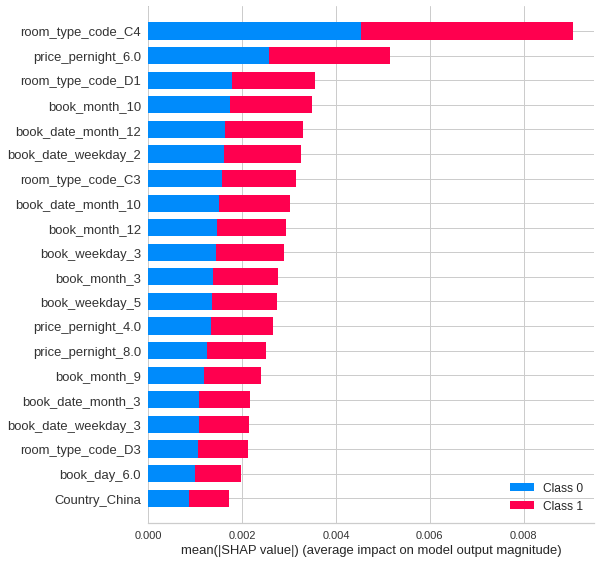

In [ ]:
interpret_model(tuned_rf)

In [ ]:
evaluate_model(tuned_rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

# Check on test data

In [ ]:
pred_df = predict_model(tuned_rf, data=data_unseen)
pred_df

,booking_date,Country,room_type_code,Status,stay_duration,price_pernight,book_month,book_day,book_weekday,book_date,Label,Score
0,2013-07-01 09:45:04+00:00,Spain,A1,Checked Out,2,60.250000,7,1,0,2013-07-01,1,0.9040
1,2013-07-01 12:47:20+00:00,France,D2,Checked Out,3,26.070000,7,1,0,2013-07-01,1,0.9476
2,2013-07-01 14:58:43+00:00,Pakistan,D3,Checked Out,3,26.600000,7,1,0,2013-07-01,1,0.9397
3,2013-07-01 15:40:57+00:00,Germany,C3,Checked Out,1,26.990000,7,1,0,2013-07-01,1,0.9115
4,2013-07-02 06:18:38+00:00,Poland,C4,Cancelled,0,32.080000,7,2,1,2013-07-02,1,0.9333
...,...,...,...,...,...,...,...,...,...,...,...,...
1610,2015-02-14 07:42:33+00:00,Germany,D1,Checked Out,4,25.210000,2,14,5,2015-02-14,1,0.9662
1611,2015-02-16 12:17:35+00:00,China,D1,Checked Out,2,25.210000,2,16,0,2015-02-16,1,0.9743
1612,2015-02-16 15:23:36+00:00,"Iran, Islamic Republic Of",A1,Checked Out,1,34.333333,2,16,0,2015-02-16,1,0.9679
1613,2015-02-18 02:44:49+00:00,France,D2,Checked Out,2,23.955000,2,18,2,2015-02-18,1,0.9506


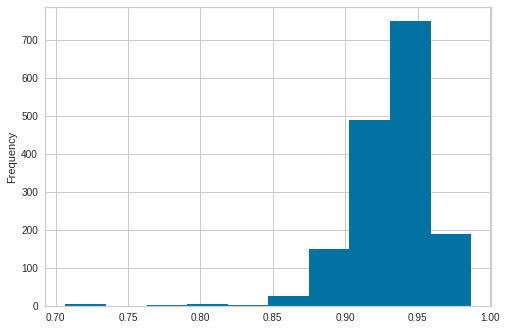

In [ ]:
pred_df['Score'].plot(kind='hist')

In [ ]:
data_unseen['Status'].value_counts()

Checked Out    1520
Cancelled        95
Name: Status, dtype: int64